<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [48]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')

from typing import Tuple
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px
%matplotlib inline
from matplotlib import pyplot as plt

from datetime import datetime

In [23]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [24]:
def get_windowed_batch(lines, session_length, window_size):
    start_ind = 0
    end_ind = session_length

    while start_ind < len(lines) - 1:
        to_return_lines = lines[start_ind:end_ind]
        start_ind += window_size
        end_ind += window_size
        yield to_return_lines

In [83]:
#session_timespan – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
#unique_sites – число уникальных сайтов в сессии
#start_hour – час начала сессии (то есть час в записи минимального timestamp среди десяти)
#day_of_week – день недели (то есть день недели в записи минимального timestamp среди десяти)

def prepare_train_set_with_fe(path_to_csv_files,
                                    session_length=10, window_size=10):
    assert window_size <= session_length
    assert window_size > 0

    def preproc_url(url):
        url = url.split('.')
        if url[0] == 'www':
            url = url[1:]
        if len(url) > 3:
            url = url[-3:]
        url = '.'.join(url)
        return url

    data = []
    for user_id, filename in tqdm(enumerate(glob(path_to_csv_files + '/*'))):
        with open(filename, 'r+') as reader:
            reader.readline() # пропускаем первую строку

            lines = reader.readlines()
            # читаем батчами по session_length строк
            for batch in get_windowed_batch(lines, session_length, window_size):
                sites = list(map(lambda x: preproc_url(x.split(',')[1].strip()), batch))
                timestamps = list(map(lambda x: datetime.strptime(x.split(',')[0].strip(), '%Y-%m-%d %H:%M:%S'), batch))

                sites += [0] * (session_length - len(sites))

                session_timespan = [(max(timestamps) - min(timestamps)).seconds]
                unique_sites = [len(set(sites))]
                start_hour = [min(timestamps).hour]
                day_of_week = [min(timestamps).weekday()]
                end_hour = [max(timestamps).hour]
                start_month = [min(timestamps).month]
                start_year = [min(timestamps).year]
                site_time = [round(session_timespan[0] / unique_sites[0], 1)]

                data.append([user_id] + sites + session_timespan +
                            unique_sites + start_hour + day_of_week +
                            end_hour + start_month + start_year + site_time)

    data = pd.DataFrame(columns=['user_id'] + [f'site_{i}' for i in range(session_length)]
                                + ['session_timespan']
                                + ['unique_sites']
                                + ['start_hour']
                                + ['day_of_week']
                                + ['end_hour']
                                + ['start_month']
                                + ['start_year']
                                + ['site_time'], data=data)

    data.index.name = 'session_id'
    return data

In [84]:
def prepare_count_vect_train_set_window(path_to_csv_files,
                                    session_length=10, window_size=10, max_df=1.0, min_df=1) -> Tuple[csr_matrix, pd.DataFrame, np.array]:

    features = ['session_timespan', 'unique_sites', 'start_hour',
                'day_of_week', 'end_hour', 'start_month', 'start_year', 'site_time']

    def tokenize_text(text):
        text = text.split()
        return text

    cv = CountVectorizer(stop_words=['0'], tokenizer=tokenize_text, max_df=max_df, min_df=min_df)

    data = prepare_train_set_with_fe(path_to_csv_files, session_length, window_size)

    X, X_features, y = data.drop('user_id', axis=1), \
                       data[features], \
                       data['user_id'].values

    X['combined'] = X[[f'site_{i}' for i in range(session_length)]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    X_matrix = cv.fit_transform(X['combined'])

    return X_matrix, X_features, y

**Проверим функцию на игрушечном примере.**

In [85]:
%%time
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA,
                                                         '3users'),
                                            session_length=10)
train_data_toy.head()

3it [00:00, 599.87it/s]

Wall time: 18 ms


,user_id,site_0,site_1,site_2,site_3,site_4,site_5,site_6,site_7,site_8,site_9,session_timespan,unique_sites,start_hour,day_of_week,end_hour,start_month,start_year,site_time
session_id,,,,,,,,,,,,,,,,,,,
0,0,vk.com,oracle.com,oracle.com,geo.mozilla.org,oracle.com,google.com,accounts.google.com,mail.google.com,apis.google.com,plus.google.com,7998,8,9,4,11,11,2013,999.8
1,0,vk.com,google.com,google.com,google.com,0,0,0,0,0,0,60,3,12,4,12,11,2013,20.0
2,1,vk.com,oracle.com,football.kulichki.ru,football.kulichki.ru,oracle.com,0,0,0,0,0,7935,4,9,4,11,11,2013,1983.8
3,2,meduza.io,google.com,oracle.com,google.com,oracle.com,google.com,google.com,mail.google.com,yandex.ru,meduza.io,7998,5,9,4,11,11,2013,1599.6
4,2,meduza.io,google.com,oracle.com,0,0,0,0,0,0,0,1471,4,12,4,12,11,2013,367.8


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [86]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA,
                                                            '10users'),
                                               session_length=10)

10it [00:01,  5.54it/s]

Wall time: 1.85 s


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [88]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA,
                                                             '150users'),
                                                session_length=10)

150it [00:16,  8.95it/s]


Wall time: 17.3 s


## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [89]:
id_name_dict = {0: 'Mary-Kate', 1: 'Ashley', 2: 'Lindsey', 3: 'Naomi', 4: 'Avril',
               5: 'Bob', 6: 'Bill', 7: 'John', 8: 'Dick', 9: 'Ed'}
train_data_10users['user_id'] = train_data_10users['user_id'].map(id_name_dict)

In [90]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*).

<AxesSubplot:>

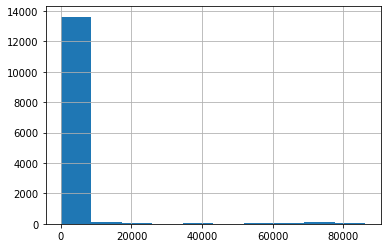

In [91]:
train_data_10users['session_timespan'].hist()

2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*unique_sites*).

<AxesSubplot:>

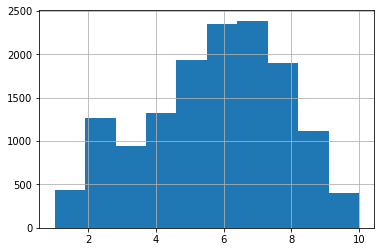

In [92]:
train_data_10users['unique_sites'].hist()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

In [93]:
px.histogram(train_data_10users, x='unique_sites', color='user_id', barmode="overlay")

4. Постройте гистограмму распределения часа начала сессии (*start_hour*).

<AxesSubplot:>

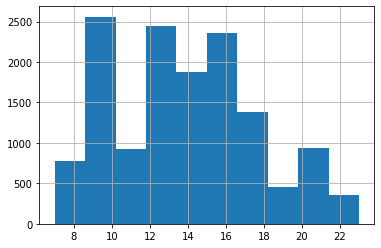

In [94]:
train_data_10users['start_hour'].hist()

5. Постройте гистограммы распределения часа начала сессии (*start_hour*).

In [28]:
px.histogram(train_data_10users, x='start_hour', color='user_id', barmode="overlay")

6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*).

<AxesSubplot:>

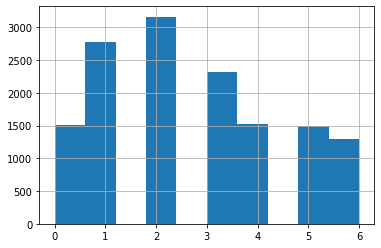

In [29]:
train_data_10users['day_of_week'].hist()

7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*).

In [31]:
px.histogram(train_data_10users, x='day_of_week', color='user_id', barmode="overlay", )

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

распределение униклаьных сайтов в сессии для Avril и Bill сильно отличается от остальных пользователей. Они посещают чаще всего не более 3 различных сайтов. Bill начинает свои сессии обычно в утренние и вечерние часы, когда Lindsey и Ashley заходят в интернет только с утра. Остальные в среднем заходят в обед. Видно, что Bill посещает веб-сайты по выходным, а Lindsey предпочитает заходить в среду.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [96]:
cv_train_data_10users, _, _ = prepare_count_vect_train_set_window(os.path.join(PATH_TO_DATA,
                                                            '10users'),
                                               session_length=10)

10it [00:01,  5.40it/s]


**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [97]:
top10_sites_by_freqs = pd.DataFrame(cv_train_data_10users.toarray()).iloc[:,:-4].sum(axis=0).sort_values(ascending=False)[:10]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

In [98]:
px.bar(top10_sites_by_freqs)

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [17]:
cv_train_data_10users['session_timespan'].median()

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [18]:
cv_train_data_10users['day_of_week'].median()

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [20]:
train_data_150users['start_hour'].median()

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [100]:
train_data_150users['unique_sites'].median()

6.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

Добавлено в основную функцию

## Перезапись данных в более удобном формате

In [101]:
%%time
import itertools

data_lengths = []

for num_users in [10, 150]:
    for max_df, min_df in itertools.product([1.0, 0.85, 0.7], [0.01, 10, 5, 1]):
        for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
            if window_size <= session_length and (window_size, session_length) != (10, 10):
                X, X_features, y = prepare_count_vect_train_set_window(os.path.join(PATH_TO_DATA,f'{num_users}users'),
                                                              session_length=session_length, window_size=window_size,
                                                                  max_df=max_df, min_df=min_df)
                data_lengths.append(X.shape[0])

                with open(os.path.join(PATH_TO_DATA,
                                       f'X_sparse_{num_users}users_s{session_length}_w{window_size}_max{max_df}_min{min_df}.pkl'),
                          'wb') as pkl:
                    pickle.dump(X, pkl, protocol=2)
                with open(os.path.join(PATH_TO_DATA,
                                       f'X_features_{num_users}users_s{session_length}_w{window_size}_max{max_df}_min{min_df}.pkl'),
                          'wb') as pkl:
                    pickle.dump(X_features, pkl, protocol=2)
                with open(os.path.join(PATH_TO_DATA,
                                       f'y_{num_users}users_s{session_length}_w{window_size}_max{max_df}_min{min_df}.pkl'),
                          'wb') as pkl:
                    pickle.dump(y, pkl, protocol=2)

10it [00:02,  3.87it/s]
10it [00:03,  2.73it/s]
10it [00:02,  4.19it/s]
10it [00:01,  5.75it/s]
10it [00:04,  2.13it/s]
10it [00:03,  3.08it/s]
10it [00:02,  4.25it/s]
10it [00:01,  5.52it/s]
10it [00:02,  4.23it/s]
10it [00:03,  2.86it/s]
10it [00:02,  4.27it/s]
10it [00:01,  5.46it/s]
10it [00:04,  2.10it/s]
10it [00:03,  2.73it/s]
10it [00:02,  4.04it/s]
10it [00:01,  5.40it/s]
10it [00:02,  4.25it/s]
10it [00:03,  2.63it/s]
10it [00:02,  4.10it/s]
10it [00:01,  5.39it/s]
10it [00:04,  2.14it/s]
10it [00:03,  2.98it/s]
10it [00:02,  4.16it/s]
10it [00:01,  5.16it/s]
10it [00:02,  4.03it/s]
10it [00:03,  2.97it/s]
10it [00:02,  4.37it/s]
10it [00:01,  5.83it/s]
10it [00:04,  2.10it/s]
10it [00:03,  2.87it/s]
10it [00:02,  4.28it/s]
10it [00:01,  5.35it/s]
10it [00:02,  3.95it/s]
10it [00:03,  2.87it/s]
10it [00:02,  4.24it/s]
10it [00:01,  5.26it/s]
10it [00:04,  2.16it/s]
10it [00:03,  3.07it/s]
10it [00:02,  4.13it/s]
10it [00:01,  5.30it/s]
10it [00:02,  4.12it/s]
10it [00:03,  2.

Wall time: 59min 12s


* Необходимо продумать приведение сайтов друг к другу (google.com и www.google.com - одно и то же). Задания в курсе подобного нет